# Example 6.6: Cliff Walking

Cliff walking example ([cliff_walkinf.py](https://github.com/ShangtongZhang/reinforcement-learning-an-introduction/blob/master/chapter06/cliff_walking.py)) from [Reinforcement Learning: An Introduction](https://github.com/ShangtongZhang/reinforcement-learning-an-introduction) translated to Julia 1.0


Copyright (C)

2016-2018 Shangtong Zhang(zhangshangtong.cpp@gmail.com)  
2016 Kenta Shimada(hyperkentakun@gmail.com)

### Libraries to use

In [3]:
import Plots
import Distributions
Plots.pyplot();

Global variables

In [4]:
# world height
WORLD_HEIGHT = 4

# world width
WORLD_WIDTH = 12

# probability for exploration
ε = 0.1

# step size
α = 0.5

# gamma for Q-Learning and Expected Sarsa
γ = 1

# all possible actions
ACTION_UP = 1
ACTION_DOWN = 2
ACTION_LEFT = 3
ACTION_RIGHT = 4
ACTIONS = [ACTION_UP, ACTION_DOWN, ACTION_LEFT, ACTION_RIGHT]

# initial state action pair values
START = [4, 1]
GOAL = [4, 12];

### step Function

In [11]:
function step_(state, action)
    i, j = state
    if action == ACTION_UP
        next_state = [max(i - 1, 1), j]
    elseif action == ACTION_LEFT
        next_state = [i, max(j - 1, 1)]
    elseif action == ACTION_RIGHT
        next_state = [i, min(j + 1, WORLD_WIDTH )]
    elseif action == ACTION_DOWN
        next_state = [min(i + 1, WORLD_HEIGHT ), j]
    else
        @assert False
    end

    reward = -1
    if (action == ACTION_DOWN && i == 2 && 1 <= j <= 10) || (
        action == ACTION_RIGHT && state == START)
        reward = -100
        next_state = START
    end

    return next_state, reward
end

step_ (generic function with 1 method)

### choose_action function

In [13]:
# choose an action based on epsilon greedy algorithm
function choose_action(state, q_value)
    if rand(Distributions.Binomial(1, ε)) == 1
        action = rand(ACTIONS)
    else
        values_ = q_value[state[1], state[2], :]
        action = rand([action_ for (action_, value_) in enumerate(values_) if value_ == maximum(values_)])
    end
    return action
end

choose_action (generic function with 1 method)

### Sarsa function

In [15]:
# an episode with Sarsa
# @q_value: values for state action pair, will be updated
# @expected: if True, will use expected Sarsa algorithm
# @step_size: step size for updating
# @return: total rewards within this episode
function sarsa(q_value, expected=false, step_size=α)
    state = START
    action = choose_action(state, q_value)
    rewards = 0.0
    while state != GOAL
        next_state, reward = step_(state, action)
        next_action = choose_action(next_state, q_value)
        rewards += reward
        if !expected
            target = q_value[next_state[1], next_state[2], next_action]
        else
            # calculate the expected value of new state
            target = 0.0
            q_next = q_value[next_state[1], next_state[2], :]
            best_actions = findall(q_next == maximum(q_next))
            for action_ in ACTIONS
                if action_ in best_actions
                    target += ((1.0 - ε) / length(best_actions) + EPSILON / length(ACTIONS)) * q_value[next_state[1], next_state[2], action_]
                else
                    target += ε / len(ACTIONS) * q_value[next_state[1], next_state[2], action_]
                end
            end
        end
        target *= γ
        q_value[state[1], state[2], action] += step_size * (
                reward + target - q_value[state[1], state[2], action])
        state = next_state
        action = next_action
    end
    return rewards
end

sarsa (generic function with 3 methods)

### Q-learning function

In [22]:
# an episode with Q-Learning
# @q_value: values for state action pair, will be updated
# @step_size: step size for updating
# @return: total rewards within this episode
function q_learning(q_value, step_size=α)
    state = START
    rewards = 0.0
    while state != GOAL
        action = choose_action(state, q_value)
        next_state, reward = step_(state, action)
        rewards += reward
        # Q-Learning update
        q_value[state[1], state[2], action] += step_size * (
                reward + γ * maximum(q_value[next_state[1], next_state[2], :]) -
                q_value[state[1], state[2], action])
        state = next_state
    end
    return rewards
end

q_learning (generic function with 2 methods)

### Function to print optimal policy

In [61]:
function print_optimal_policy(q_value)
    optimal_policy = []
    for i in range(1, stop=WORLD_HEIGHT)
        push!(optimal_policy,[])
        for j in range(1, stop=WORLD_WIDTH)
            if [i, j] == GOAL
                append!(optimal_policy[end], 'G')
                continue
            end
            bestAction = argmax(q_value[i, j, :])
            if bestAction == ACTION_UP
                append!(optimal_policy[end], 'U')
            elseif bestAction == ACTION_DOWN
                append!(optimal_policy[end], 'D')
            elseif bestAction == ACTION_LEFT
                append!(optimal_policy[end], 'L')
            elseif bestAction == ACTION_RIGHT
                append!(optimal_policy[end], 'R')
            end
        end
    end
    for row in optimal_policy
        println(row)
    end
end

print_optimal_policy (generic function with 1 method)

## Figure 6.4

In [58]:
# Use multiple runs instead of a single run and a sliding window
# With a single run I failed to present a smooth curve
# However the optimal policy converges well with a single run
# Sarsa converges to the safe path, while Q-Learning converges to the optimal path

# episodes of each run
episodes = 500

# perform 40 independent runs
runs = 50

rewards_sarsa = zeros(episodes)
rewards_q_learning = zeros(episodes)
q_sarsa = zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))
q_q_learning = copy(q_sarsa)
for r in range(1, stop=runs)
    q_sarsa = zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))
    q_q_learning = copy(q_sarsa)
    for i in range(1, stop=episodes)
        # cut off the value by -100 to draw the figure more elegantly
        # rewards_sarsa[i] += max(sarsa(q_sarsa), -100)
        # rewards_q_learning[i] += max(q_learning(q_q_learning), -100)
        rewards_sarsa[i] += sarsa(q_sarsa)
        rewards_q_learning[i] += q_learning(q_q_learning)
    end
end

# averaging over independt runs
rewards_sarsa /= runs
rewards_q_learning /= runs



#plt.savefig('../images/figure_6_4.png')
#plt.close()



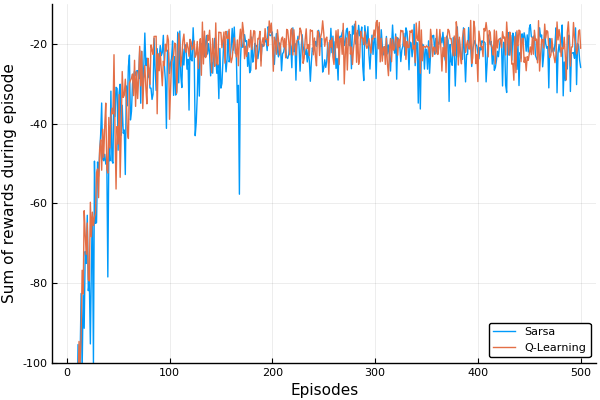

In [59]:
# draw reward curves
Plots.plot(rewards_sarsa, label="Sarsa", fmt = :png)
Plots.plot!(rewards_q_learning, label="Q-Learning")
Plots.xaxis!("Episodes")
Plots.yaxis!("Sum of rewards during episode")
Plots.ylims!(-100,-10)

In [62]:
# display optimal policy
println("Sarsa Optimal Policy:")
print_optimal_policy(q_sarsa)
println("Q-Learning Optimal Policy:")
print_optimal_policy(q_q_learning)

Sarsa Optimal Policy:
Any['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
Any['U', 'R', 'U', 'R', 'R', 'R', 'L', 'U', 'L', 'R', 'D', 'D']
Any['R', 'D', 'D', 'R', 'R', 'D', 'R', 'R', 'R', 'R', 'R', 'D']
Any['U', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'G']
Q-Learning Optimal Policy:
Any['L', 'R', 'R', 'D', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
Any['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
Any['R', 'R', 'R', 'R', 'R', 'R', 'D', 'R', 'D', 'R', 'D', 'D']
Any['U', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'G']


## Figura 6.6

In [70]:
step_sizes = range(0.1, stop=1.1, step=0.1)
episodes = 1000
runs = 10

ASY_SARSA = 0
ASY_EXPECTED_SARSA = 1
ASY_QLEARNING = 2
INT_SARSA = 3
INT_EXPECTED_SARSA = 4
INT_QLEARNING = 5
#methods = range(1, stop=6)

performace = zeros((6, length(step_sizes)))
for run in range(1, stop=runs)
    for ind, step_size in list(zip(range(1, stop=length(step_sizes)), step_sizes))
        q_sarsa = zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))
        q_expected_sarsa = copy(q_sarsa)
        q_q_learning = copy(q_sarsa)
        for ep in range(episodes)
            sarsa_reward = sarsa(q_sarsa, expected=False, step_size=step_size)
            expected_sarsa_reward = sarsa(q_expected_sarsa, expected=True, step_size=step_size)
            q_learning_reward = q_learning(q_q_learning, step_size=step_size)
            performace[ASY_SARSA, ind] += sarsa_reward
            performace[ASY_EXPECTED_SARSA, ind] += expected_sarsa_reward
            performace[ASY_QLEARNING, ind] += q_learning_reward

            if ep < 100
                performace[INT_SARSA, ind] += sarsa_reward
                performace[INT_EXPECTED_SARSA, ind] += expected_sarsa_reward
                performace[INT_QLEARNING, ind] += q_learning_reward
            end
        end
    end
end

#performace[:3, :] /= episodes * runs
#performace[3:, :] /= 100 * runs
#labels = ["Asymptotic Sarsa", "Asymptotic Expected Sarsa", "Asymptotic Q-Learning",
#          "Interim Sarsa", "Interim Expected Sarsa", "Interim Q-Learning"]

#for method, label in zip(methods, labels):
#    plt.plot(step_sizes, performace[method, :], label=label)
#Plots.xaxis!('alpha')
#Plots.yxis!('reward per episode')
#plt.legend()

#plt.savefig('../images/figure_6_6.png')
#plt.close()

LoadError: syntax: invalid iteration specification